# 📰 Fake News Detection: Model Evaluation and Comparison

This project aims to build and evaluate multiple machine learning models to classify news articles as either **fake** or **real**. Using a labeled dataset of real and fake news articles, we explore data preprocessing, feature engineering, model training, and performance evaluation.



### Imports & Setup
This cell includes all necessary Python libraries for data processing, visualization, modeling, and evaluation.


In [18]:
# Core Libraries
import pandas as pd
import numpy as np

#  Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#  Text Preprocessing
import re
import string

#  Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Utilities
import warnings
warnings.filterwarnings('ignore')


Load and prepare data

In [19]:
# Load datasets
true_df = pd.read_csv('data\True.csv')
fake_df = pd.read_csv('data\Fake.csv')

# Add labels
true_df['label'] = 1  # real
fake_df['label'] = 0  # fake

# Combine and shuffle
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Preview
df.head()



,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


EDA:
- Check class distribution
- Visualize word count per article
- Generate word clouds


label
0    23481
1    21417
Name: count, dtype: int64
title      0
text       0
subject    0
date       0
label      0
dtype: int64


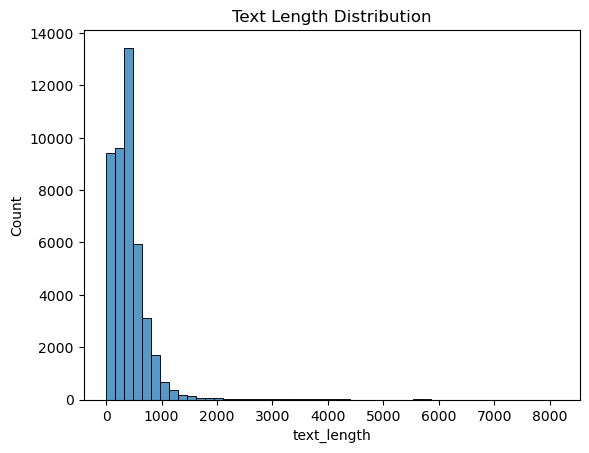

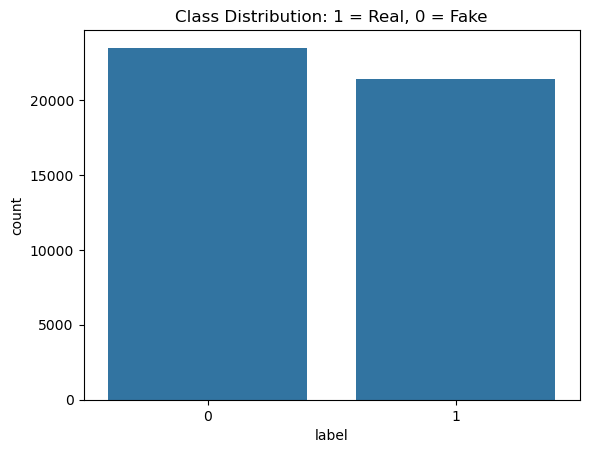

In [21]:
# Basic stats
print(df['label'].value_counts())
print(df.isnull().sum())

# Add text length column
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot text length distribution
sns.histplot(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.show()

# Plot class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution: 1 = Real, 0 = Fake')
plt.show()


### 🧠 EDA Insights

- The majority of news articles fall between 200 and 1000 words, with a right-skewed distribution. This could influence model performance if very short or very long articles behave differently.
- The class distribution is relatively balanced (Real ≈ Fake), which is ideal for classification modeling and ensures fair evaluation of model performance.


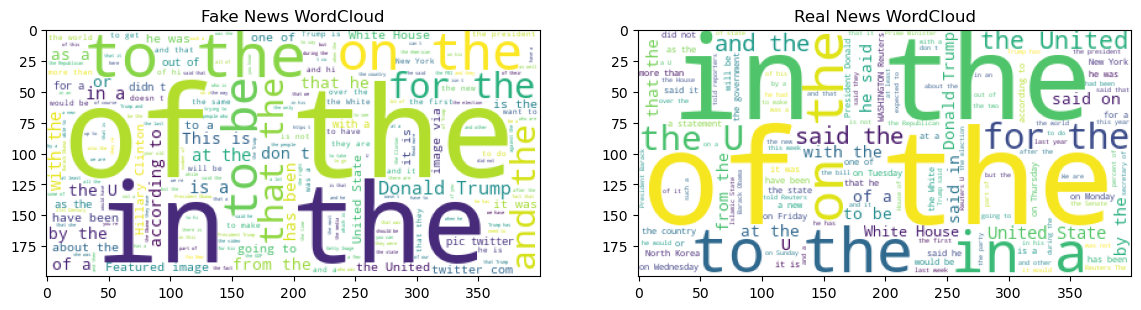

In [22]:
# Generate word clouds
fake_text = " ".join(fake_df['text'].astype(str))
real_text = " ".join(true_df['text'].astype(str))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(stopwords='english', background_color='white').generate(fake_text))
plt.title('Fake News WordCloud')

plt.subplot(1,2,2)
plt.imshow(WordCloud(stopwords='english', background_color='white').generate(real_text))
plt.title('Real News WordCloud')
plt.show()


### 🔤 Word Cloud Interpretation

- **Fake News Articles** tend to contain generic language and references to individuals (e.g., "Trump", "Twitter"), and potentially click-driven phrases like "Featured image".
- **Real News Articles** include more formal structures, references to news agencies (e.g., "Reuters"), temporal context (e.g., "Tuesday"), and verifiable attributions (e.g., "said the Prime Minister").

While both categories contain common stopwords, real news appears to use more **objective and structured** language, aligning with journalistic standards. This distinction might be useful in feature engineering.


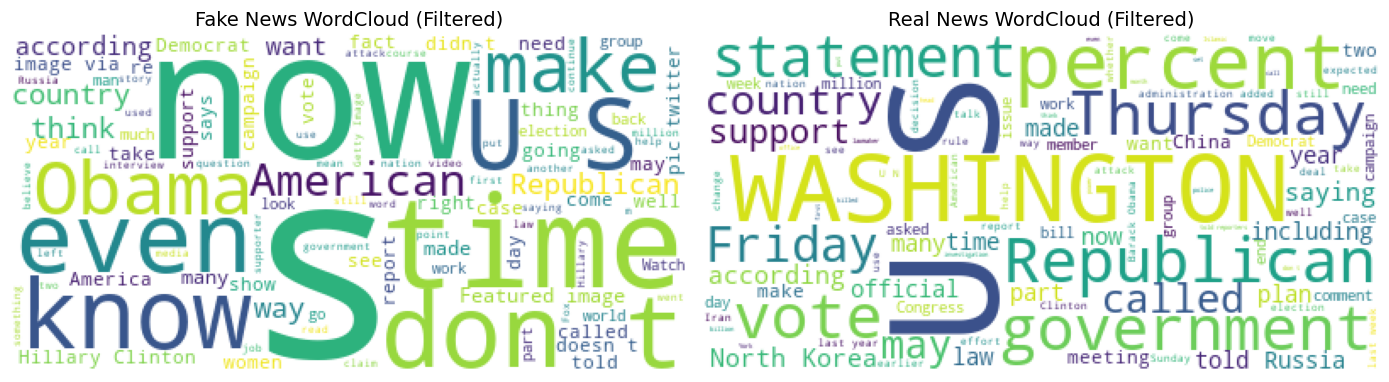

In [23]:
from wordcloud import WordCloud, STOPWORDS

# Extend default stopwords with custom domain-specific ones
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'donald', 'trump', 'said', 'say', 'will', 'new', 'also', 'one', 'us', 'mr',
    'reuters', 'monday', 'tuesday', 'wednesday', 'united', 'states', 'white',
    'house', 'president', 'minister', 'would', 'could', 'state', 'news', 'people'
])

# Combine all article text into one string for each class
fake_text = " ".join(fake_df['text'].astype(str))
real_text = " ".join(true_df['text'].astype(str))

# Plot word clouds with improved stopword removal
plt.figure(figsize=(14,6))

# Fake news word cloud
plt.subplot(1,2,1)
plt.imshow(
    WordCloud(stopwords=custom_stopwords, background_color='white', max_words=100).generate(fake_text)
)
plt.axis('off')
plt.title('Fake News WordCloud (Filtered)', fontsize=14)

# Real news word cloud
plt.subplot(1,2,2)
plt.imshow(
    WordCloud(stopwords=custom_stopwords, background_color='white', max_words=100).generate(real_text)
)
plt.axis('off')
plt.title('Real News WordCloud (Filtered)', fontsize=14)

plt.tight_layout()
plt.show()


### 🔤 Cleaned Word Cloud Interpretation

The cleaned word clouds (after removing default and domain-specific stopwords) reveal clearer language patterns:

#### 🟥 Fake News Articles
- Use emotionally charged and persuasive terms like “know”, “want”, “make”, and “even”.
- Feature first-person and subjective language (e.g., “me”, “my”).
- Contain politically sensitive names (e.g., “Obama”, “Hillary Clinton”) — indicating potential bias or sensationalism.

#### 🟩 Real News Articles
- Focus on factual and formal reporting with terms like “statement”, “percent”, “called”, “official”.
- Reference global topics and locations (e.g., “North Korea”, “Russia”, “Washington”).
- Include structured time references (e.g., “Thursday”, “Friday”) — typical in journalism.

These differences support the hypothesis that fake news tends to be emotional and opinionated, while real news maintains a formal, fact-based tone.


Text preprocessing

In [24]:
# Clean text: remove punctuation and lowercase
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


Vectorization with TF-IDF 

In [25]:
# Convert text into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X = tfidf.fit_transform(df['clean_text'])

# Labels
y = df['label']


Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train Multiple Models

In [27]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        verbosity=0,
        random_state=42
    )
}

# Train
for name, model in models.items():
    model.fit(X_train, y_train)



Evaluate and Compare Models

In [28]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    print("=" * 50)
    print(f"🔍 {name} Evaluation")
    print("-" * 50)
    
    print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("🎯 ROC AUC Score:", round(roc_auc_score(y_test, y_pred), 4))
    print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
    print("=" * 50 + "\n\n")



🔍 Logistic Regression Evaluation
--------------------------------------------------
✅ Accuracy: 0.9839
🎯 ROC AUC Score: 0.9838

📊 Confusion Matrix:
 [[4595   74]
 [  71 4240]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4669
           1       0.98      0.98      0.98      4311

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



🔍 Random Forest Evaluation
--------------------------------------------------
✅ Accuracy: 0.9578
🎯 ROC AUC Score: 0.9571

📊 Confusion Matrix:
 [[4545  124]
 [ 255 4056]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      4669
           1       0.97      0.94      0.96      4311

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980

## 🧪 Model Evaluation Summary

Below is a summary of performance metrics for each model trained on the fake news dataset:

| Model               | Accuracy | ROC AUC | Precision | Recall | F1-Score |
|---------------------|----------|---------|-----------|--------|----------|
| Logistic Regression | 98.39%   | 0.9838  | 0.98      | 0.98   | 0.98     |
| Random Forest       | 95.78%   | 0.9571  | 0.97      | 0.94   | 0.96     |
| XGBoost             | **99.65%** | **0.9966** | 1.00      | 1.00   | 1.00     |

### ✅ Insights:
- **XGBoost** outperformed the other models with near-perfect accuracy and ROC AUC.
- **Logistic Regression** also performed exceptionally well, making it a strong, interpretable baseline.
- **Random Forest** had good performance but slightly lower recall, which could affect real-world detection of fake news.

These results suggest that both XGBoost and Logistic Regression are suitable for deployment, depending on whether you prioritize performance or interpretability.


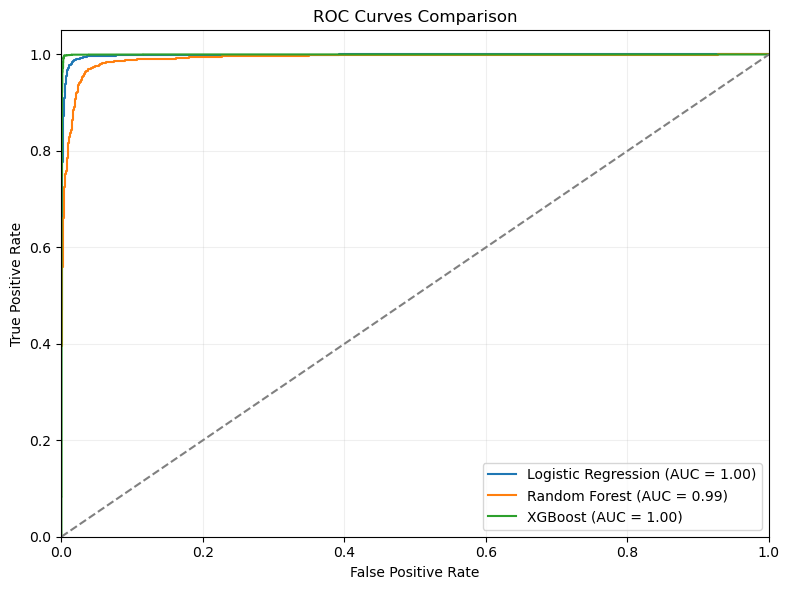

In [29]:
# ROC curves
plt.figure(figsize=(8, 6))

# Loop through models to plot ROC curves
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labels and formatting
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### 📈 ROC Curve Analysis

The ROC curves for Logistic Regression, Random Forest, and XGBoost models show how well each classifier distinguishes between real and fake news.

- **XGBoost** has the steepest curve and highest AUC (~0.996), indicating exceptional discriminative ability.
- **Logistic Regression** also performs strongly with an AUC of ~0.984.
- **Random Forest** performs well but is slightly less effective than the other two.

These results confirm that all three models are strong, with XGBoost being the best performer for deployment or production use.


Top Words from Logistic Regression (Real vs Fake)

In [30]:
# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Get model coefficients
coefficients = models["Logistic Regression"].coef_[0]

# Get top N positive and negative words
top_n = 20

# Top words indicating REAL news (label 1)
top_real_indices = np.argsort(coefficients)[-top_n:]
top_real_words = [(feature_names[i], round(coefficients[i], 4)) for i in reversed(top_real_indices)]

# Top words indicating FAKE news (label 0)
top_fake_indices = np.argsort(coefficients)[:top_n]
top_fake_words = [(feature_names[i], round(coefficients[i], 4)) for i in top_fake_indices]

# Display
print("🟢 Top words indicating REAL news:")
for word, score in top_real_words:
    print(f"{word}: {score}")

print("\n🔴 Top words indicating FAKE news:")
for word, score in top_fake_words:
    print(f"{word}: {score}")


🟢 Top words indicating REAL news:
reuters: 31.2443
wednesday: 7.9001
washington: 7.8289
thursday: 7.0941
tuesday: 6.8914
friday: 6.3015
monday: 5.9459
republican: 5.3295
minister: 5.1422
nov: 4.9905
statement: 4.9754
spokesman: 4.8977
comment: 4.7887
reporters: 4.274
year: 4.0383
presidential: 3.9442
told: 3.7877
democratic: 3.5717
month: 3.5489
killed: 3.439

🔴 Top words indicating FAKE news:
image: -7.8508
just: -7.0923
gop: -6.1862
hillary: -5.5843
images: -4.9938
america: -4.8627
wire: -4.6565
mr: -4.4576
like: -4.4381
american: -4.0796
century: -3.9694
video: -3.9553
fact: -3.7693
obama: -3.7219
daily: -3.6049
rep: -3.5553
didn: -3.543
watch: -3.299
isn: -3.2897
sen: -3.2844


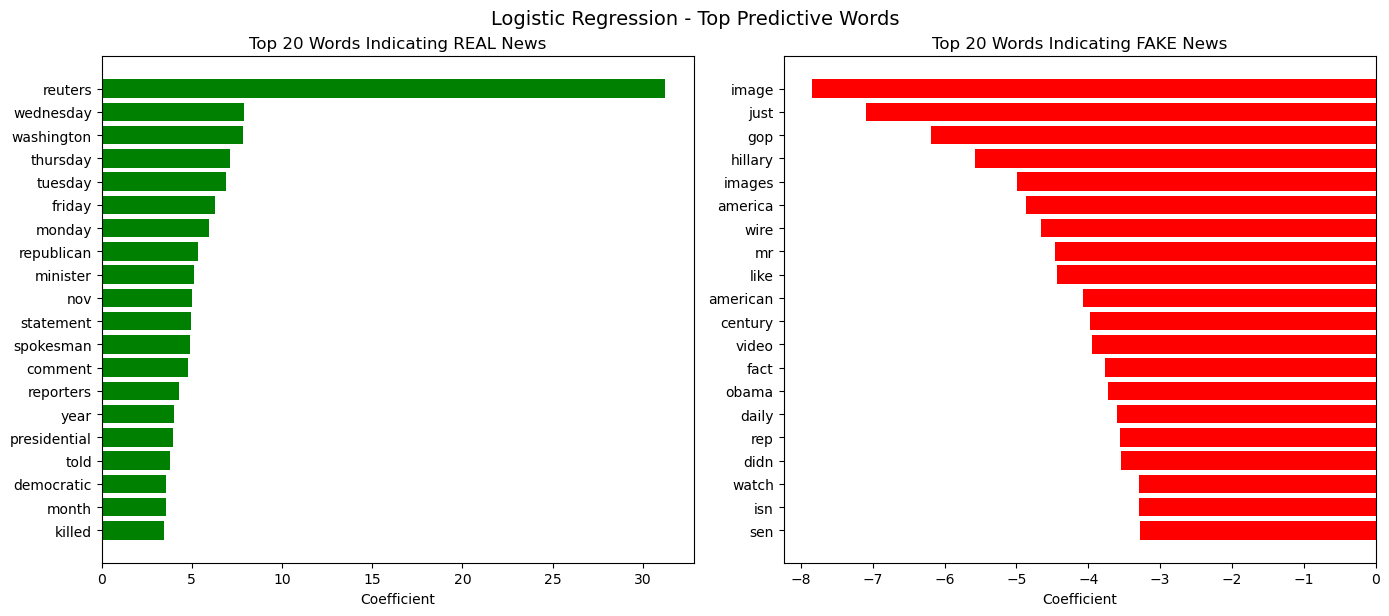

In [31]:
# Separate words and scores
real_words, real_scores = zip(*top_real_words)
fake_words, fake_scores = zip(*top_fake_words)

# Plot
plt.figure(figsize=(14, 6))

# REAL NEWS WORDS
plt.subplot(1, 2, 1)
plt.barh(real_words[::-1], real_scores[::-1], color='green')
plt.title('Top 20 Words Indicating REAL News')
plt.xlabel('Coefficient')
plt.tight_layout()

# FAKE NEWS WORDS
plt.subplot(1, 2, 2)
plt.barh(fake_words[::-1], fake_scores[::-1], color='red')
plt.title('Top 20 Words Indicating FAKE News')
plt.xlabel('Coefficient')
plt.tight_layout()

plt.suptitle('Logistic Regression - Top Predictive Words', fontsize=14, y=1.02)
plt.show()


### Top Predictive Words from Logistic Regression

By examining the model coefficients, we identified the most influential words contributing to fake and real news classification:

#### 🔴 Words strongly associated with Fake News:
- `hillary`, `obama`, `gop`, `image`, `video`, `daily`, `fact`, `just`, `like`
- These tend to reflect political bias, emotional tone, or clickbait-style content.

#### 🟢 Words strongly associated with Real News:
- `reuters`, `statement`, `spokesman`, `minister`, `tuesday`, `friday`, `reporters`
- These reflect formal journalistic structure and objective reporting style.

This analysis improves the interpretability of the model and supports our EDA findings: **fake news often relies on emotionally charged and informal language**, while **real news uses structured, factual terms and institutional sources**.


Top 20 Features from XGBoost

In [32]:
importances = models["XGBoost"].feature_importances_
indices = np.argsort(importances)[-20:]  # top 20

print("⭐ Top 20 Important Features from XGBoost:")
for i in reversed(indices):
    print(f"{feature_names[i]}: {round(importances[i], 4)}")


⭐ Top 20 Important Features from XGBoost:
reuters: 0.48969998955726624
filessupport: 0.008799999952316284
getty: 0.006300000008195639
flickr: 0.005100000184029341
century: 0.004699999932199717
image: 0.004000000189989805
saidthe: 0.0038999998942017555
aka: 0.0038999998942017555
lying: 0.0038999998942017555
thug: 0.003800000064074993
caller: 0.003700000001117587
collected: 0.003700000001117587
wire: 0.003599999938160181
explains: 0.003599999938160181
demographics: 0.003599999938160181
bannon: 0.0035000001080334187
wikileaks: 0.0035000001080334187
yahoo: 0.0035000001080334187
analysis: 0.0035000001080334187
challenge: 0.0035000001080334187


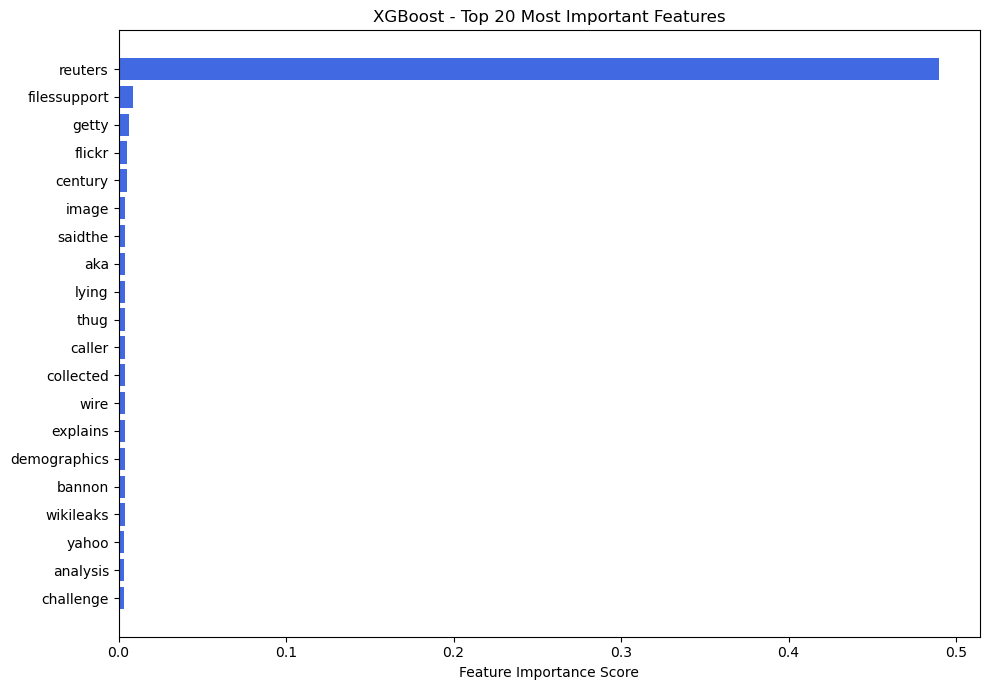

In [33]:
# Get top 20 features sorted by importance (descending)
xgb_importances = models["XGBoost"].feature_importances_
sorted_indices = np.argsort(xgb_importances)[::-1]  # full descending order
top_indices = sorted_indices[:20]  # top 20 only

# Extract feature names and scores
top_xgb_words = [feature_names[i] for i in top_indices]
top_xgb_scores = [xgb_importances[i] for i in top_indices]

# Plot
plt.figure(figsize=(10, 7))
plt.barh(top_xgb_words, top_xgb_scores, color='royalblue')
plt.gca().invert_yaxis()  # ensures top feature is at the top
plt.title('XGBoost - Top 20 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()


### 🔍 XGBoost Feature Importance

XGBoost’s most influential feature was clearly:

- **`reuters`**, with a much higher importance than all others — confirming it's a strong indicator of real, agency-based reporting.

Other important features include:
- **Potential fake news indicators**: `wikileaks`, `caller`, `lying`, `getty`, `flickr`, `filessupport`, `thug`, `bannon`
- **Neutral or analytical terms**: `analysis`, `challenge`, `collected`, `demographics`

The model appears to have picked up on patterns of source attribution and emotional tone, which supports our broader finding: **real news is tied to institutional language**, while **fake news often features emotionally or politically charged terms**.
